# 📝 Exploratory Data Analysis (EDA) Template

## 1. Project Setup
- **Objective**: 
- **Dataset Description**: 
  - Source(s): google analytics 4  
  - Size: 721 articles published in August
  - Time Period: August 2025

---

## 2. Data Overview
- Shape (721 x 14) 
- Column types (numerical, categorical, datetime, text)  
- Sample records (first few rows)  

---

## 3. Data Quality Check
- Missing values (count & %)  = There a re no row with missing values
- Duplicates  = There are no duplicates
- Outliers (basic detection)  
- Inconsistent entries  

---

## 4. Descriptive Statistics
- **Numerical features**: mean, median, std, min, max, percentiles  
- **Categorical features**: frequency tables, top categories, rare levels  
- **Datetime features**: trends over time  

---

## 5. Univariate Analysis
- Distributions of numerical variables (histograms, density plots)  
- Categorical counts (bar plots)  
- Target variable distribution (if applicable)  

---

## 6. Bivariate Analysis
- Numerical vs numerical → scatterplots, correlations  
- Categorical vs categorical → cross-tabs, chi-square  
- Numerical vs categorical → boxplots, group-wise summaries  
- Independent variables vs target variable  

---

## 7. Multivariate Analysis
- Correlation heatmap  
- Pair plots / scatter matrix  
- PCA / dimensionality reduction (if relevant)  
- Clustering patterns  

---

## 8. Feature Engineering Opportunities
- Potential derived features (ratios, bins, encodings, time-based)  
- Handling skewed distributions (transformations)  
- Handling high-cardinality categorical features  

---

## 9. Key Insights & Next Steps
- Summary of findings  
- Data cleaning actions required  
- Features to consider for modeling  
- Potential data issues (e.g., imbalance, leakage)  

---


In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import numpy as np

## Functions / Class definitions

In [2]:
# Parameters
data_folder = '../../output/monthly/'
file_name = 'top_articles_August.xlsx'

def transform_import_data(df):
    # Convert 'published' column to datetime
    df['Publication Date'] = pd.to_datetime(df['Publication Date'])
    # Insert other transformations here
    return df

def keep_month(df, month):
    return df[df['Publication Date'].dt.month == month]

def plot_distribution(df, variable):
    sns.histplot(df[variable], kde=True)
    plt.show()
    print("Skewness:", df[variable].skew())
    print("Kurtosis:", df[variable].kurt())

def detect_iqr_outliers(df, variable):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[variable] < lower_bound) | (df[variable] > upper_bound)]
    return outliers

def detect_z_outliers(df, variable):
    mean = df[variable].mean()
    std = df[variable].std()
    threshold = 3
    outliers = df[(df[variable] < mean - threshold * std) | (df[variable] > mean + threshold * std)]
    return outliers

def detect_percentile_outliers(df, variable):
    lower_bound = df[variable].quantile(0.01)
    upper_bound = df[variable].quantile(0.99)
    outliers = df[(df[variable] < lower_bound) | (df[variable] > upper_bound)]
    return outliers

def detect_outliers(df, variable, method='IQR'):
    if method == 'IQR':
        return detect_iqr_outliers(df, variable)
    elif method == 'Z-score':
        return detect_z_outliers(df, variable)
    elif method == 'Percentile':
        return detect_percentile_outliers(df, variable)
    else:
        raise ValueError("Method not recognized")
    

def normalize_distribution(df, variable, method='log'):
    if method == 'log':
        df[f'{variable}_normalized'] = df[variable].apply(lambda x: np.log(x) if x > 0 else 0)
    elif method == 'sqrt':
        df[f'{variable}_normalized'] = df[variable].apply(lambda x: np.sqrt(x) if x >= 0 else 0)
    elif method == 'cube':
        df[f'{variable}_normalized'] = df[variable].apply(lambda x: np.cbrt(x))
    elif method == 'boxcox':
        df[f'{variable}_normalized'], _ = boxcox(df[variable] + 1)  # Adding 1 to avoid issues with zero values
    else:
        raise ValueError("Normalization method not recognized")
    return df
    

## Initial Exploration

In [21]:
import pandas as pd
data = pd.read_excel(data_folder + file_name, sheet_name=0)
data = transform_import_data(data)
data = keep_month(data, 8)

data.shape


(721, 14)

In [4]:
data.dtypes

pagePath                          object
activeUsers                        int64
screenPageViews                    int64
engagementRate                   float64
bounceRate                       float64
averageSessionDuration           float64
Categoria                         object
title                             object
wordpress_category                object
published                         object
link                              object
Publication Date          datetime64[ns]
Author                            object
Title                             object
dtype: object

In [5]:
# Missing values check
data.isnull().sum()

pagePath                  0
activeUsers               0
screenPageViews           0
engagementRate            0
bounceRate                0
averageSessionDuration    0
Categoria                 0
title                     0
wordpress_category        0
published                 0
link                      0
Publication Date          0
Author                    0
Title                     0
dtype: int64

In [6]:
# Check duplicates
data.duplicated().sum()

np.int64(0)

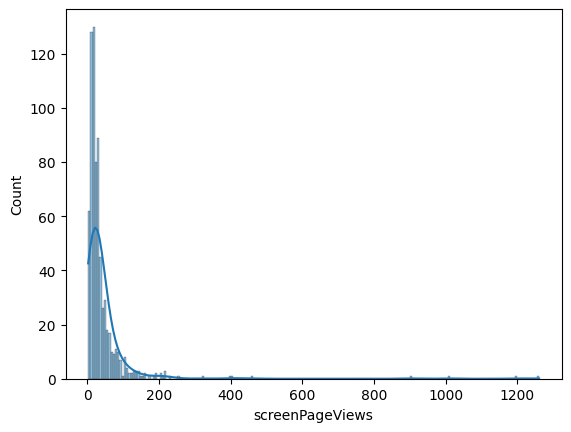

Skewness: 9.547681796991254
Kurtosis: 109.66874703182033


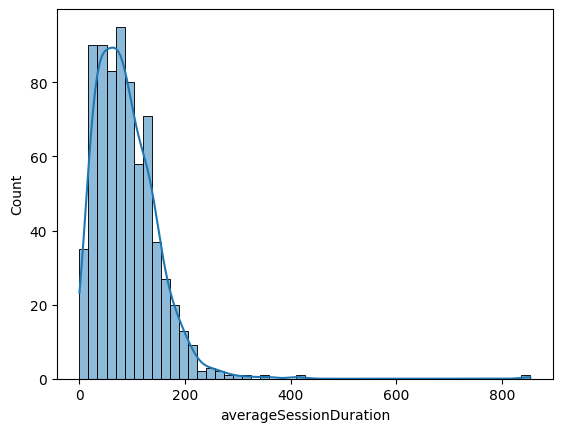

Skewness: 3.400819754679545
Kurtosis: 33.1367649283362


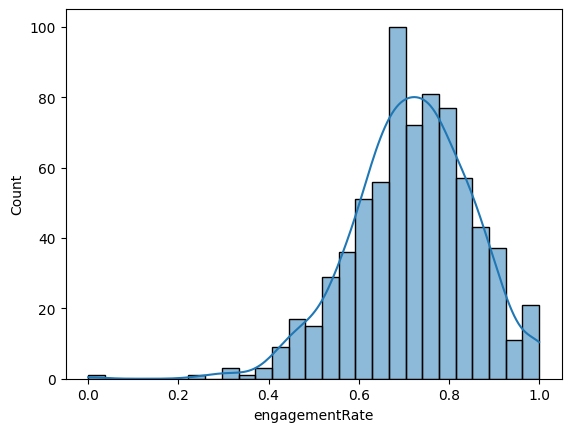

Skewness: -0.44513868540891655
Kurtosis: 1.0891452113481601


In [7]:
metrics_to_check_normality = ['screenPageViews', 'averageSessionDuration', 'engagementRate']

for metric in metrics_to_check_normality:
    plot_distribution(data, variable=metric)

In [8]:
views_outliers = detect_outliers(data, variable='screenPageViews', method='IQR')
average_duration_outliers = detect_outliers(data, variable='averageSessionDuration', method='IQR')
engagement_rate_outliers = detect_outliers(data, variable='engagementRate', method='IQR')

## Feature Engineering

### Building a composite index

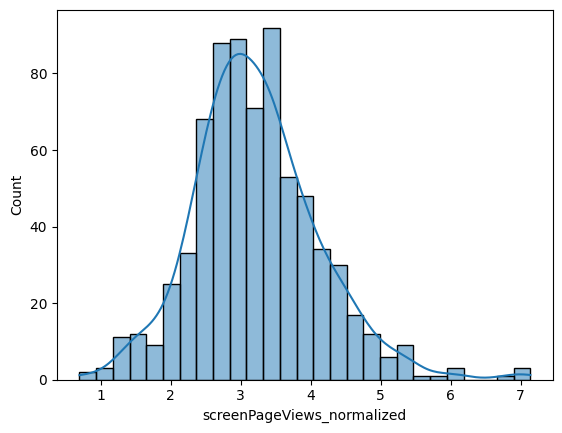

Skewness: 0.6211734445213942
Kurtosis: 1.5540123372538823


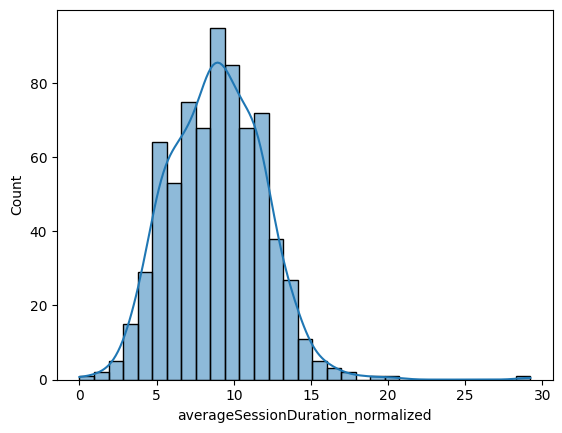

Skewness: 0.5373822891717839
Kurtosis: 2.426244345197403


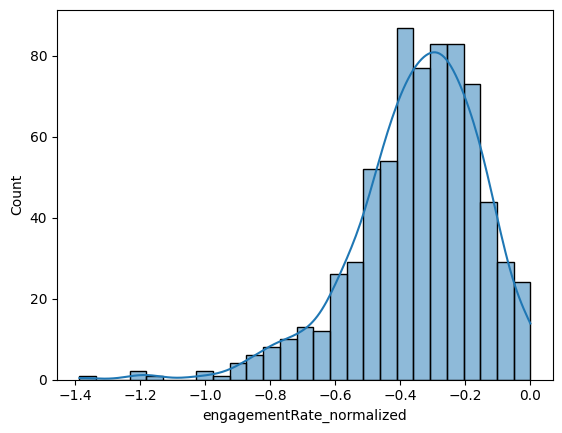

Skewness: -1.0070075473633013
Kurtosis: 2.1962440816873356


In [9]:
# Composite indicator
# Purpose of the composite indicator -> rank articles based on overall performance (ability to attract and engage users at the same time)
# Define metrics weight
weights = {
    'screenPageViews': 0.4,
    'averageSessionDuration': 0.3,
    'engagementRate': 0.3
}

normalize_distribution(data, variable='screenPageViews', method='log')
normalize_distribution(data, variable='averageSessionDuration', method='sqrt')
normalize_distribution(data, variable='engagementRate', method='log')
plot_distribution(data, variable='screenPageViews_normalized')
plot_distribution(data, variable='averageSessionDuration_normalized')
plot_distribution(data, variable='engagementRate_normalized')

## Analyze categories

In [15]:
data.groupby('Categoria')['screenPageViews'].sum().sort_values(ascending=False)

Categoria
Festival di Cinema          5575
Recensioni                  4615
News                        3631
Speciali e Magazine         3411
Serie TV                    3181
Cult Movies                 2589
Live Streaming On Demand    2148
Anticipazioni               1744
Trailers                    1375
Si farà                      974
Interviste                   483
Altro                        442
Animazione                   248
Rubriche                     224
Name: screenPageViews, dtype: int64

In [22]:
data['Categoria'].value_counts()

Categoria
Festival di Cinema          145
News                        120
Anticipazioni                74
Speciali e Magazine          73
Recensioni                   72
Cult Movies                  69
Trailers                     52
Serie TV                     38
Live Streaming On Demand     23
Altro                        14
Interviste                   14
Si farà                      11
Rubriche                      9
Animazione                    7
Name: count, dtype: int64

# Insights

In [10]:
# Explore Categories